In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
import pathlib
dataset_path= os.path.abspath("./Dataset.zip")
data_dir = tf.keras.utils.get_file('Dataset.zip', origin='file:\\'+dataset_path, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2375


In [ ]:
# healthy = list(data_dir.glob('Healthy/*'))
# PIL.Image.open(str(healthy[0]))

In [11]:
BATCH_SIZE = 32
IMG_HEIGHT = 512
IMG_WIDTH = 512

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=1,
    image_size=(IMG_HEIGHT,IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 2375 files belonging to 4 classes.
Using 1900 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=(0.2),
    subset='validation',
    seed=1,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 2375 files belonging to 4 classes.
Using 475 files for validation.


In [20]:
class_names=train_ds.class_names
print(class_names)

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']


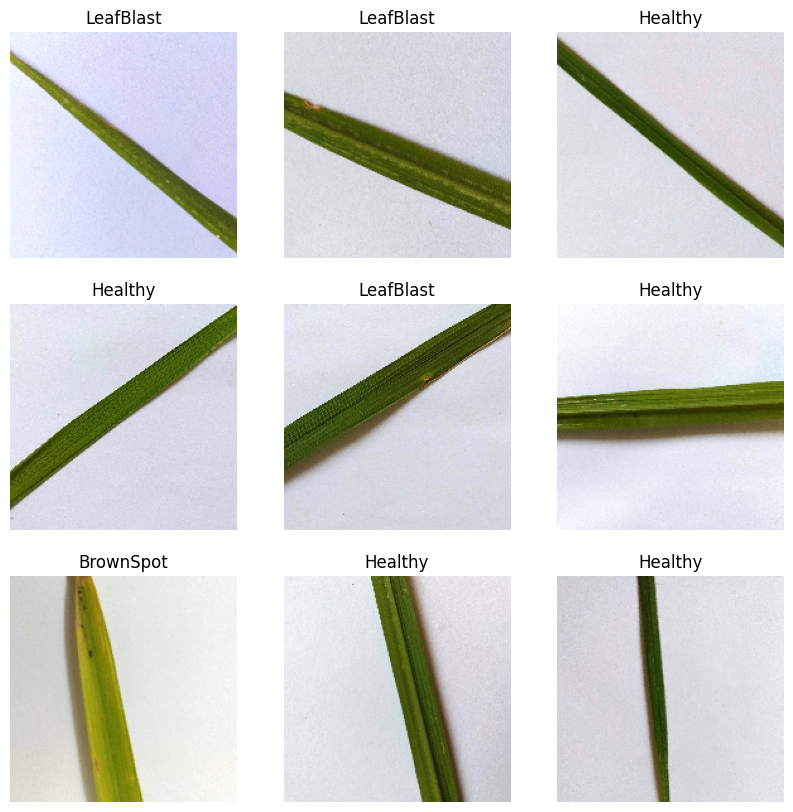

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1/255.)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, label_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.00033433954 1.0


In [78]:
NUM_CLASSES = len(class_names)

data_augmentation = Sequential([
    layers.RandomFlip('horizontal',
                      input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomRotation(0.2, fill_mode='nearest'),
    layers.RandomZoom(0.1, fill_mode='nearest'),
    layers.RandomTranslation(0.1, 0.1, fill_mode='nearest')
])

model = Sequential([
    data_augmentation,
    layers.Rescaling(1/255.),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Conv2D(512, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [79]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [80]:
model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_44 (Sequential)  (None, 512, 512, 3)       0         
                                                                 
 rescaling_23 (Rescaling)    (None, 512, 512, 3)       0         
                                                                 
 conv2d_121 (Conv2D)         (None, 510, 510, 16)      448       
                                                                 
 max_pooling2d_121 (MaxPooli  (None, 255, 255, 16)     0         
 ng2D)                                                           
                                                                 
 dropout_183 (Dropout)       (None, 255, 255, 16)      0         
                                                                 
 conv2d_122 (Conv2D)         (None, 253, 253, 32)      4640      
                                                     

In [81]:
EPOCHS=200
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/200
60/60 [==============================] - 164s 3s/step - loss: 1.4740 - accuracy: 0.2800 - val_loss: 1.3818 - val_accuracy: 0.3179
Epoch 2/200
60/60 [==============================] - 162s 3s/step - loss: 1.3837 - accuracy: 0.2874 - val_loss: 1.3786 - val_accuracy: 0.3179
Epoch 3/200
60/60 [==============================] - 162s 3s/step - loss: 1.3836 - accuracy: 0.2868 - val_loss: 1.3807 - val_accuracy: 0.3179
Epoch 4/200
60/60 [==============================] - 162s 3s/step - loss: 1.3835 - accuracy: 0.2874 - val_loss: 1.3782 - val_accuracy: 0.3179
Epoch 5/200
60/60 [==============================] - 161s 3s/step - loss: 1.3828 - accuracy: 0.2874 - val_loss: 1.3764 - val_accuracy: 0.3179
Epoch 6/200
60/60 [==============================] - 160s 3s/step - loss: 1.3831 - accuracy: 0.2874 - val_loss: 1.3758 - val_accuracy: 0.3179
Epoch 7/200
60/60 [==============================] - 160s 3s/step - loss: 1.3826 - accuracy: 0.2874 - val_loss: 1.3758 - val_accuracy: 0.3179
Epoch 

In [1]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

In [83]:
model.save('Padicure_model_v0_4')

INFO:tensorflow:Assets written to: Padicure_model_v0_4\assets


INFO:tensorflow:Assets written to: Padicure_model_v0_4\assets


In [16]:
# Model versi 0.3, size: 152MB
model_v0_3 = tf.keras.models.load_model('Padicure_model_v0_3')
model_v0_3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 512, 512, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 510, 510, 16)      448       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 255, 255, 16)     0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 255, 255, 16)      0         
                                                                 
 conv2d_20 (Conv2D)          (None, 253, 253, 32)      4640      
                                                     

In [15]:
#Train dan Test accuracy model V0.3
train_loss, train_acc = model_v0_3.evaluate(train_ds, verbose=2)
val_loss, val_acc = model_v0_3.evaluate(val_ds, verbose=2)
print('Model V0.3, training accuracy: {:5.2f}%'.format(100 * train_acc))
print('Model V0.3, validation accuracy: {:5.2f}%'.format(100 * val_acc))

60/60 - 35s - loss: 0.3711 - accuracy: 0.8668 - 35s/epoch - 585ms/step
15/15 - 10s - loss: 0.5136 - accuracy: 0.8316 - 10s/epoch - 663ms/step
Model V0.3, training accuracy: 86.68%
Model V0.3, validation accuracy: 83.16%


In [17]:
# Model versi 0.4, size: 72.3MB
model_v0_4 = tf.keras.models.load_model('Padicure_model_v0_4')
model_v0_4.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_44 (Sequential)  (None, 512, 512, 3)       0         
                                                                 
 rescaling_23 (Rescaling)    (None, 512, 512, 3)       0         
                                                                 
 conv2d_121 (Conv2D)         (None, 510, 510, 16)      448       
                                                                 
 max_pooling2d_121 (MaxPooli  (None, 255, 255, 16)     0         
 ng2D)                                                           
                                                                 
 dropout_183 (Dropout)       (None, 255, 255, 16)      0         
                                                                 
 conv2d_122 (Conv2D)         (None, 253, 253, 32)      4640      
                                                     

In [18]:
train_loss, train_acc = model_v0_4.evaluate(train_ds, verbose=2)
val_loss, val_acc = model_v0_4.evaluate(val_ds, verbose=2)
print('Model V0.4, training accuracy: {:5.2f}%'.format(100 * train_acc))
print('Model V0.4, validation accuracy: {:5.2f}%'.format(100 * val_acc))

60/60 - 40s - loss: 0.3647 - accuracy: 0.8642 - 40s/epoch - 665ms/step
15/15 - 11s - loss: 0.4735 - accuracy: 0.8253 - 11s/epoch - 704ms/step
Model V0.4, training accuracy: 86.42%
Model V0.4, validation accuracy: 82.53%
